In [1]:
import numpy as np
import nibabel as nib
import glob
from tensorflow.keras.utils import to_categorical
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.utils import to_categorical

from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()

In [2]:

TRAIN_DATASET_PATH = 'D:\GIKI\Deep Learning\Project\Dataset\BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/'
#VALIDATION_DATASET_PATH = 'BraTS2020_ValidationData/MICCAI_BraTS2020_ValidationData'

test_image_flair=nib.load(TRAIN_DATASET_PATH + 'BraTS20_Training_355/BraTS20_Training_355_flair.nii').get_fdata()
print(test_image_flair.max())
#Scalers are applied to 1D so let us reshape and then reshape back to original shape. 
test_image_flair=scaler.fit_transform(test_image_flair.reshape(-1, test_image_flair.shape[-1])).reshape(test_image_flair.shape)


test_image_t1=nib.load(TRAIN_DATASET_PATH + 'BraTS20_Training_355/BraTS20_Training_355_t1.nii').get_fdata()
test_image_t1=scaler.fit_transform(test_image_t1.reshape(-1, test_image_t1.shape[-1])).reshape(test_image_t1.shape)

test_image_t1ce=nib.load(TRAIN_DATASET_PATH + 'BraTS20_Training_355/BraTS20_Training_355_t1ce.nii').get_fdata()
test_image_t1ce=scaler.fit_transform(test_image_t1ce.reshape(-1, test_image_t1ce.shape[-1])).reshape(test_image_t1ce.shape)

test_image_t2=nib.load(TRAIN_DATASET_PATH + 'BraTS20_Training_355/BraTS20_Training_355_t2.nii').get_fdata()
test_image_t2=scaler.fit_transform(test_image_t2.reshape(-1, test_image_t2.shape[-1])).reshape(test_image_t2.shape)

test_mask=nib.load(TRAIN_DATASET_PATH + 'BraTS20_Training_355/BraTS20_Training_355_seg.nii').get_fdata()
test_mask=test_mask.astype(np.uint8)

print(np.unique(test_mask))  #0, 1, 2, 4 (Need to reencode to 0, 1, 2, 3)
test_mask[test_mask==4] = 3  #Reassign mask values 4 to 3
print(np.unique(test_mask)) 

1854.603271484375
[0 1 2 4]
[0 1 2 3]


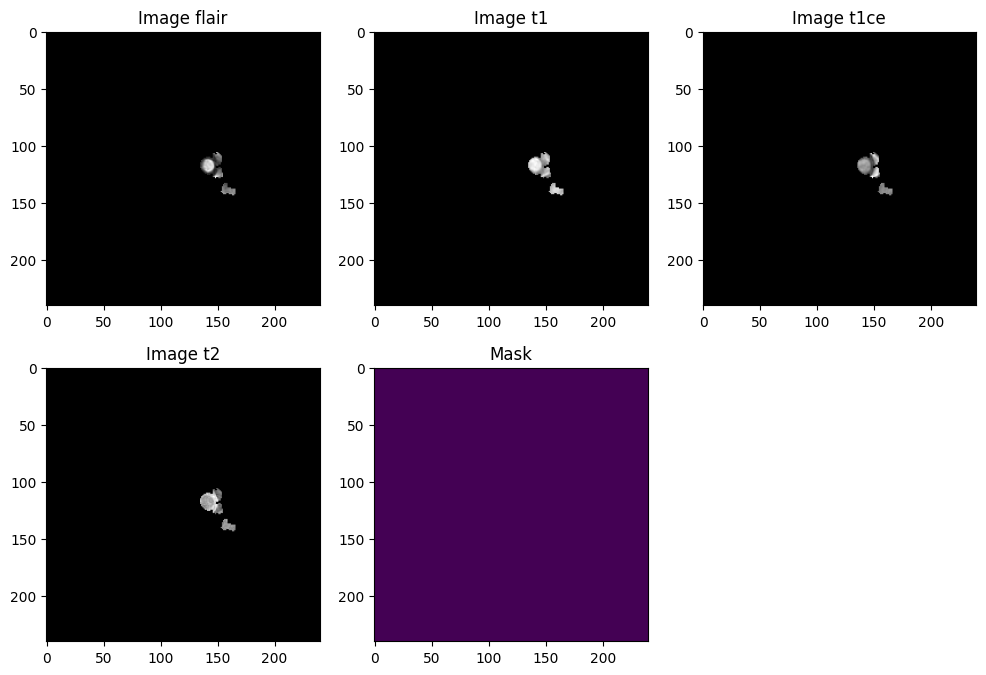

In [3]:
import random
n_slice=random.randint(0, test_mask.shape[2])

plt.figure(figsize=(12, 8))

plt.subplot(231)
plt.imshow(test_image_flair[:,:,n_slice], cmap='gray')
plt.title('Image flair')
plt.subplot(232)
plt.imshow(test_image_t1[:,:,n_slice], cmap='gray')
plt.title('Image t1')
plt.subplot(233)
plt.imshow(test_image_t1ce[:,:,n_slice], cmap='gray')
plt.title('Image t1ce')
plt.subplot(234)
plt.imshow(test_image_t2[:,:,n_slice], cmap='gray')
plt.title('Image t2')
plt.subplot(235)
plt.imshow(test_mask[:,:,n_slice])
plt.title('Mask')
plt.show()

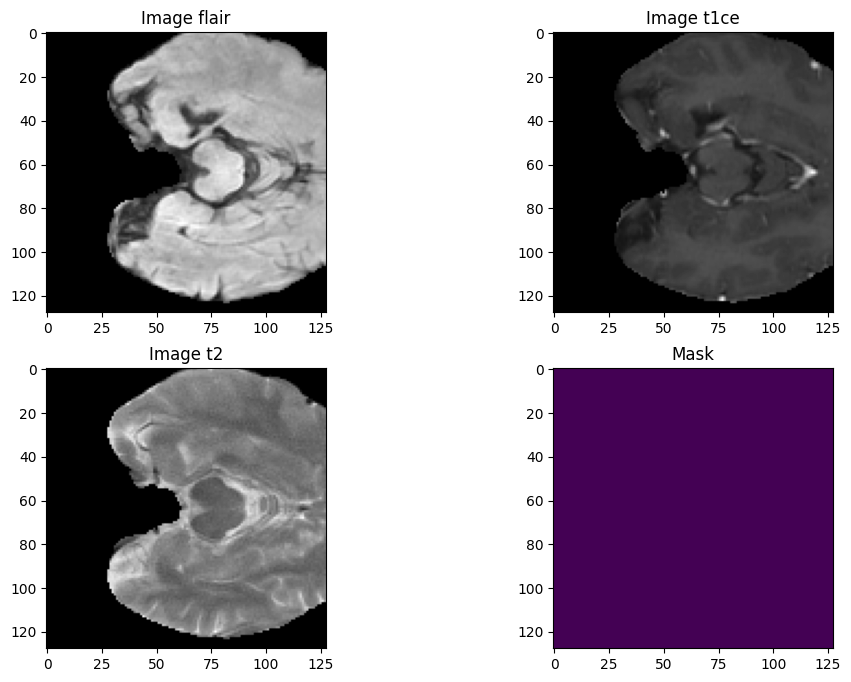

In [4]:

#PART 2: Explore the process of combining images to channels and divide them to patches
#Includes...
#Combining all 4 images to 4 channels of a numpy array.
#Flair, T1CE, annd T2 have the most information
#Combine t1ce, t2, and flair into single multichannel image

combined_x = np.stack([test_image_flair, test_image_t1ce, test_image_t2], axis=3)

#Crop to a size to be divisible by 64 so we can later extract 64x64x64 patches. 
#cropping x, y, and z
#combined_x=combined_x[24:216, 24:216, 13:141]

combined_x=combined_x[56:184, 56:184, 13:141] #Crop to 128x128x128x4

#Do the same for mask
test_mask = test_mask[56:184, 56:184, 13:141]

n_slice=random.randint(0, test_mask.shape[2])
plt.figure(figsize=(12, 8))

plt.subplot(221)
plt.imshow(combined_x[:,:,n_slice, 0], cmap='gray')
plt.title('Image flair')
plt.subplot(222)
plt.imshow(combined_x[:,:,n_slice, 1], cmap='gray')
plt.title('Image t1ce')
plt.subplot(223)
plt.imshow(combined_x[:,:,n_slice, 2], cmap='gray')
plt.title('Image t2')
plt.subplot(224)
plt.imshow(test_mask[:,:,n_slice])
plt.title('Mask')
plt.show()

In [5]:
np.save('D:\GIKI\Deep Learning\Project\Dataset\BraTS2020_TrainingData/combined255.npy', combined_x)
#Verify image is being read properly
#my_img=imread('BraTS2020_TrainingData/combined255.tif')

my_img=np.load('D:\GIKI\Deep Learning\Project\Dataset\BraTS2020_TrainingData/combined255.npy')

test_mask = to_categorical(test_mask, num_classes=4)

C:\Users\Pc\AppData\Local\Temp\ipykernel_5232\601351593.py:1: DeprecationWarning: <tifffile.imsave> is deprecated. Use tifffile.imwrite
  imsave('D:\GIKI\Deep Learning\Project\Dataset\BraTS2020_TrainingData/combined255.tif', combined_x)


In [6]:


#Now let us apply the same as above to all the images...
#Merge channels, crop, patchify, save
#GET DATA READY =  GENERATORS OR OTHERWISE

#Keras datagenerator does ntot support 3d

# # # images lists harley
#t1_list = sorted(glob.glob('BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/*/*t1.nii'))
t2_list = sorted(glob.glob('D:/GIKI\Deep Learning/Project/Dataset/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/*/*t2.nii'))
t1ce_list = sorted(glob.glob('D:/GIKI/Deep Learning/Project\Dataset/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/*/*t1ce.nii'))
flair_list = sorted(glob.glob('D:/GIKI\Deep Learning/Project/Dataset/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/*/*flair.nii'))
mask_list = sorted(glob.glob('D:/GIKI/Deep Learning/Project/Dataset/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/*/*seg.nii'))

#Each volume generates 18 64x64x64x4 sub-volumes. 
#Total 369 volumes = 6642 sub volumes

In [7]:
import os
import numpy as np
import nibabel as nib
from keras.utils import to_categorical

# Define the directories
images_dir = r'D:/GIKI/Deep Learning/Project/Dataset/BraTS2020_TrainingData/input_data_3channels/images'
masks_dir = r'D:/GIKI/Deep Learning/Project/Dataset/BraTS2020_TrainingData/input_data_3channels/masks'

# Create the directories if they do not exist
os.makedirs(images_dir, exist_ok=True)
os.makedirs(masks_dir, exist_ok=True)

for img in range(len(t2_list)):  # Using t1_list as all lists are of same size
    print("Now preparing image and masks number:", img)
    
    temp_image_t2 = nib.load(t2_list[img]).get_fdata()
    temp_image_t2 = scaler.fit_transform(temp_image_t2.reshape(-1, temp_image_t2.shape[-1])).reshape(temp_image_t2.shape)
    
    temp_image_t1ce = nib.load(t1ce_list[img]).get_fdata()
    temp_image_t1ce = scaler.fit_transform(temp_image_t1ce.reshape(-1, temp_image_t1ce.shape[-1])).reshape(temp_image_t1ce.shape)
    
    temp_image_flair = nib.load(flair_list[img]).get_fdata()
    temp_image_flair = scaler.fit_transform(temp_image_flair.reshape(-1, temp_image_flair.shape[-1])).reshape(temp_image_flair.shape)
    
    temp_mask = nib.load(mask_list[img]).get_fdata().astype(np.uint8)
    temp_mask[temp_mask == 4] = 3  # Reassign mask values 4 to 3
    
    temp_combined_images = np.stack([temp_image_flair, temp_image_t1ce, temp_image_t2], axis=3)
    
    # Crop
    temp_combined_images = temp_combined_images[56:184, 56:184, 13:141]
    temp_mask = temp_mask[56:184, 56:184, 13:141]
    
    val, counts = np.unique(temp_mask, return_counts=True)
    
    if (1 - (counts[0] / counts.sum())) > 0.01:  # At least 1% useful volume
        print("Save Me")
        temp_mask = to_categorical(temp_mask, num_classes=4)
        np.save(os.path.join(images_dir, f'image_{img}.npy'), temp_combined_images)
        np.save(os.path.join(masks_dir, f'mask_{img}.npy'), temp_mask)
    else:
        print("I am useless")


In [8]:
import os
import splitfolders  # Import the split-folders library

# Define input and output folders
input_folder = r'D:/GIKI/Deep Learning/Project/Dataset/BraTS2020_TrainingData/input_data_3channels/'
output_folder = r'D:/GIKI/Deep Learning/Project/Dataset/BraTS2020_TrainingData/input_data_128/'

# Ensure output directory exists
os.makedirs(output_folder, exist_ok=True)

# Split the dataset with a ratio of 75% training and 25% validation
splitfolders.ratio(
    input_folder, 
    output=output_folder, 
    seed=42, 
    ratio=(.75, .25),  # 75% for training and 25% for validation
    group_prefix=None
)

print("Dataset successfully split into training and validation sets!")


### Data Generator

In [10]:
import os
import numpy as np
from tensorflow.keras.utils import to_categorical

# Load images or masks from a directory

def load_img(img_dir, img_list, normalize=False, num_classes=None):
    images = []
    for image_name in img_list:
        if image_name.split('.')[-1] == 'npy':
            file_path = os.path.join(img_dir, image_name)
            try:
                image = np.load(file_path)
                if normalize:
                    image = image / 255.0  # Normalize images if required
                # Ensure no further processing for already one-hot encoded masks
                if num_classes and image.shape[-1] != num_classes:
                    raise ValueError(f"Unexpected mask shape: {image.shape}. Expected shape with {num_classes} channels.")
                images.append(image)
            except FileNotFoundError:
                print(f"File not found: {file_path}")
    return np.array(images)




# Data generator function
def imageLoader(img_dir, img_list, mask_dir, mask_list, batch_size, num_classes=None):
    L = len(img_list)

    while True:
        batch_start = 0
        batch_end = batch_size

        while batch_start < L:
            limit = min(batch_end, L)
                       
            X = load_img(img_dir, img_list[batch_start:limit], normalize=True)
            Y = load_img(mask_dir, mask_list[batch_start:limit], normalize=False, num_classes=num_classes)

            # Debug the shapes after loading
            print(f"Loaded Image Batch Shape: {X.shape}")
            print(f"Loaded Mask Batch Shape: {Y.shape}")

            # Ensure masks are one-hot encoded
            if num_classes and Y.shape[-1] != num_classes:
                Y = to_categorical(Y, num_classes=num_classes)
                print(f"One-hot encoded masks. New shape: {Y.shape}")

            # Ensure no extra dimensions in masks
            if len(Y.shape) == 6:
                print("Extra dimensions detected in masks. Squeezing...")
                Y = np.squeeze(Y, axis=-1)

            # Debug the final shapes
            print(f"Yielding Image Batch Shape: {X.shape}")
            print(f"Yielding Mask Batch Shape: {Y.shape}")

            yield (X, Y)

            batch_start += batch_size   
            batch_end += batch_size




In [11]:
# Example test
img_dir = r"D:\\GIKI\\Deep Learning\\Project\\Dataset\\BraTS2020_TrainingData\\input_data_128\\train\\images"
mask_dir = r"D:\\GIKI\\Deep Learning\\Project\\Dataset\\BraTS2020_TrainingData\\input_data_128\\train\\masks"

img_list = ["image_1.npy", "image_2.npy", "image_3.npy", "image_4.npy"]
mask_list = ["mask_1.npy", "mask_2.npy", "mask_3.npy", "mask_4.npy"]
batch_size = 4
num_classes = 4

gen = imageLoader(img_dir, img_list, mask_dir, mask_list, batch_size, num_classes=num_classes)
X, Y = next(gen)
print(f"Image Batch Shape: {X.shape}")
print(f"Mask Batch Shape: {Y.shape}")


File not found: D:\\GIKI\\Deep Learning\\Project\\Dataset\\BraTS2020_TrainingData\\input_data_128\\train\\images\image_4.npy
File not found: D:\\GIKI\\Deep Learning\\Project\\Dataset\\BraTS2020_TrainingData\\input_data_128\\train\\masks\mask_4.npy
Loaded Image Batch Shape: (3, 128, 128, 128, 3)
Loaded Mask Batch Shape: (3, 128, 128, 128, 4)
Yielding Image Batch Shape: (3, 128, 128, 128, 3)
Yielding Mask Batch Shape: (3, 128, 128, 128, 4)
Image Batch Shape: (3, 128, 128, 128, 3)
Mask Batch Shape: (3, 128, 128, 128, 4)


Loaded Image Batch Shape: (1, 128, 128, 128, 3)
Loaded Mask Batch Shape: (1, 128, 128, 128, 4)
Yielding Image Batch Shape: (1, 128, 128, 128, 3)
Yielding Mask Batch Shape: (1, 128, 128, 128, 4)


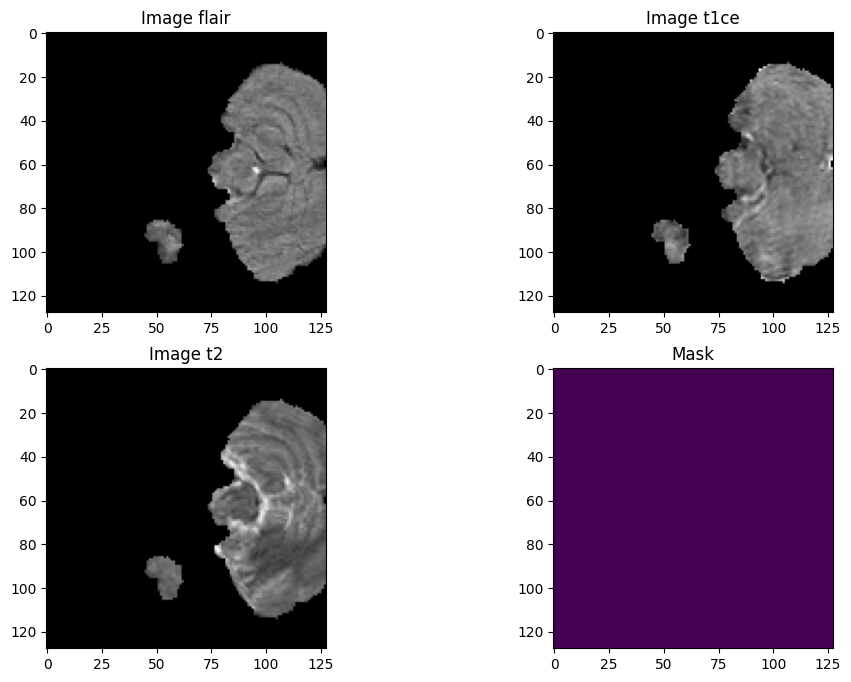

In [12]:
from matplotlib import pyplot as plt
import random
import os

# Use raw strings or consistent forward slashes
train_img_dir = r"D:\GIKI\Deep Learning\Project\Dataset\BraTS2020_TrainingData\input_data_128\train\images"
train_mask_dir = r"D:\GIKI\Deep Learning\Project\Dataset\BraTS2020_TrainingData\input_data_128\train\masks"

# Check if directories exist
if not os.path.exists(train_img_dir):
    raise FileNotFoundError(f"Image directory not found: {train_img_dir}")
if not os.path.exists(train_mask_dir):
    raise FileNotFoundError(f"Mask directory not found: {train_mask_dir}")

# List files in directories
train_img_list = os.listdir(train_img_dir)
train_mask_list = os.listdir(train_mask_dir)

batch_size = 1

# Assuming `imageLoader` is a custom function that you've implemented
train_img_datagen = imageLoader(train_img_dir, train_img_list, 
                                train_mask_dir, train_mask_list, batch_size)

# Verify generator.... In Python 3, next() is renamed to __next__()
img, msk = train_img_datagen.__next__()

# Visualization
img_num = random.randint(0, img.shape[0] - 1)
test_img = img[img_num]
test_mask = msk[img_num]
test_mask = np.argmax(test_mask, axis=3)

n_slice = random.randint(0, test_mask.shape[2] - 1)
plt.figure(figsize=(12, 8))

plt.subplot(221)
plt.imshow(test_img[:, :, n_slice, 0], cmap='gray')
plt.title('Image flair')
plt.subplot(222)
plt.imshow(test_img[:, :, n_slice, 1], cmap='gray')
plt.title('Image t1ce')
plt.subplot(223)
plt.imshow(test_img[:, :, n_slice, 2], cmap='gray')
plt.title('Image t2')
plt.subplot(224)
plt.imshow(test_mask[:, :, n_slice])
plt.title('Mask')
plt.show()


###Model 

In [13]:
import torch
import torch.nn as nn
from efficientnet_pytorch import EfficientNet


class ConvLSTMCell(nn.Module):
    """ConvLSTM Cell"""
    def __init__(self, input_dim, hidden_dim, kernel_size, padding):
        super(ConvLSTMCell, self).__init__()
        self.hidden_dim = hidden_dim
        self.conv = nn.Conv3d(input_dim + hidden_dim, 4 * hidden_dim, kernel_size, padding=padding)

    def forward(self, x, hidden_state):
        h, c = hidden_state
        combined = torch.cat([x, h], dim=1)  # Concatenate input and hidden state
        conv_output = self.conv(combined)
        cc_i, cc_f, cc_o, cc_g = torch.split(conv_output, self.hidden_dim, dim=1)
        i = torch.sigmoid(cc_i)
        f = torch.sigmoid(cc_f)
        o = torch.sigmoid(cc_o)
        g = torch.tanh(cc_g)
        c_next = f * c + i * g
        h_next = o * torch.tanh(c_next)
        return h_next, c_next


class ConvLSTM(nn.Module):
    """ConvLSTM Module"""
    def __init__(self, input_dim, hidden_dim, kernel_size, num_layers):
        super(ConvLSTM, self).__init__()
        self.layers = nn.ModuleList([
            ConvLSTMCell(input_dim if i == 0 else hidden_dim, hidden_dim, kernel_size, padding=1)
            for i in range(num_layers)
        ])

    def forward(self, x):
        batch_size, _, depth, height, width = x.size()
        h, c = [None] * len(self.layers), [None] * len(self.layers)
        for i, layer in enumerate(self.layers):
            h[i] = torch.zeros(batch_size, layer.hidden_dim, depth, height, width, device=x.device)
            c[i] = torch.zeros(batch_size, layer.hidden_dim, depth, height, width, device=x.device)

        for i, layer in enumerate(self.layers):
            h[i], c[i] = layer(x, (h[i], c[i]))
            x = h[i]

        return x


class HybridUNet(nn.Module):
    """Hybrid UNet with EfficientNet Encoder and ConvLSTM"""
    def __init__(self, img_channels, num_classes):
        super(HybridUNet, self).__init__()
        self.encoder = EfficientNet.from_pretrained('efficientnet-b0')

        # Channel reduction for ConvLSTM input
        self.channel_reduction = nn.Conv3d(1280, 256, kernel_size=1)

        # ConvLSTM
        self.convlstm = ConvLSTM(input_dim=256, hidden_dim=256, kernel_size=(3, 3, 3), num_layers=1)

        # Decoder blocks
        self.decoder = nn.ModuleList([
            self.decoder_block(256, 128),  # ConvLSTM output to decoder
            self.decoder_block(128, 64),
            self.decoder_block(64, 32),
            self.decoder_block(32, 16)
        ])

        # Final segmentation layer
        self.segmentation_head = nn.Conv3d(16, num_classes, kernel_size=1)

    def decoder_block(self, in_channels, out_channels):
        return nn.Sequential(
            nn.Conv3d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv3d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.ConvTranspose3d(out_channels, out_channels, kernel_size=2, stride=2)
        )

    def forward(self, x):
        batch_size, channels, depth, height, width = x.size()
        features = []

        # Process each depth slice as a 2D input for EfficientNet
        for d in range(depth):
            slice_2d = x[:, :, d, :, :]  # Extract a single 2D slice: (batch_size, channels, height, width)

            # If the number of input channels is not 3, replicate channels to match
            if channels == 1:
                slice_2d = slice_2d.repeat(1, 3, 1, 1)  # Replicate the single channel 3 times
            elif channels != 3:
                raise ValueError(f"Input must have 1 or 3 channels, but got {channels}")

            # Pass the slice through EfficientNet
            encoded = self.encoder.extract_features(slice_2d)  # Shape: (batch_size, 1280, height', width')
            encoded = encoded.unsqueeze(2)  # Add the depth dimension back for stacking
            features.append(encoded)

        # Stack features along the depth dimension
        volumetric_features = torch.cat(features, dim=2)  # Shape: (batch_size, 1280, depth, height', width')

        # Reduce channels for ConvLSTM
        reduced_features = self.channel_reduction(volumetric_features)  # Shape: (batch_size, 256, depth, height', width')

        # Pass through ConvLSTM
        lstm_output = self.convlstm(reduced_features)  # Shape: (batch_size, 256, depth, height', width')

        # Decode the features
        x = lstm_output
        for decoder in self.decoder:
            x = decoder(x)

        # Final segmentation map
        x = self.segmentation_head(x)  # Shape: (batch_size, num_classes, depth, height, width)

        # Reshape depth and spatial dimensions to match input
        x = nn.functional.interpolate(x, size=(depth, height, width), mode='trilinear', align_corners=True)
        return x


# Test the model
if __name__ == "__main__":
    model = HybridUNet(img_channels=3, num_classes=4)
    input_tensor = torch.rand(1, 3, 128, 128, 128)  # Batch size 1, volumetric input
    output = model(input_tensor)
    print("Output shape:", output.shape)  # Should match (1, 4, 128, 128, 128)


Loaded pretrained weights for efficientnet-b0
Output shape: torch.Size([1, 4, 128, 128, 128])


###### Training and prediction

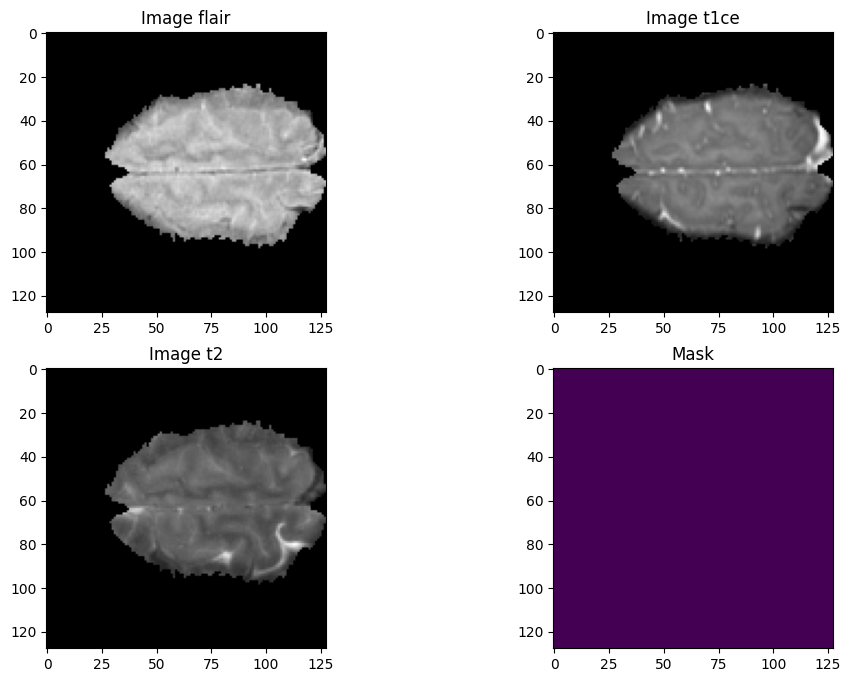

In [14]:
import os
import numpy as np
from matplotlib import pyplot as plt
import random

# Use raw string (r"") to avoid escape sequence issues
train_img_dir = r"D:\GIKI\Deep Learning\Project\Dataset\BraTS2020_TrainingData\input_data_128\train\images"
train_mask_dir = r"D:\GIKI\Deep Learning\Project\Dataset\BraTS2020_TrainingData\input_data_128\train\masks"

# Get the list of image and mask files
img_list = os.listdir(train_img_dir)
msk_list = os.listdir(train_mask_dir)

# Ensure the number of images matches
num_images = len(img_list)

# Select a random image
img_num = random.randint(0, num_images - 1)

# Use os.path.join to construct the file paths
test_img_path = os.path.join(train_img_dir, img_list[img_num])
test_mask_path = os.path.join(train_mask_dir, msk_list[img_num])

# Load the image and mask
test_img = np.load(test_img_path)
test_mask = np.load(test_mask_path)

# Process the mask (assuming it's one-hot encoded)
test_mask = np.argmax(test_mask, axis=3)

# Visualize a random slice
n_slice = random.randint(0, test_mask.shape[2] - 1)
plt.figure(figsize=(12, 8))

plt.subplot(221)
plt.imshow(test_img[:, :, n_slice, 0], cmap='gray')
plt.title('Image flair')

plt.subplot(222)
plt.imshow(test_img[:, :, n_slice, 1], cmap='gray')
plt.title('Image t1ce')

plt.subplot(223)
plt.imshow(test_img[:, :, n_slice, 2], cmap='gray')
plt.title('Image t2')

plt.subplot(224)
plt.imshow(test_mask[:, :, n_slice])
plt.title('Mask')

plt.show()


In [15]:
import pandas as pd
import numpy as np
import glob

columns = ['0', '1', '2', '3']
class_counts = {key: 0 for key in columns}

train_mask_list = sorted(glob.glob('BraTS2020_TrainingData/input_data_128/train/masks/*.npy'))
for img in range(len(train_mask_list)):
    temp_image = np.load(train_mask_list[img])
    temp_image = np.argmax(temp_image, axis=3)
    val, counts = np.unique(temp_image, return_counts=True)
    
    # Update class counts
    for v, c in zip(val, counts):
        class_counts[str(v)] += c

# Convert to DataFrame for readability
df = pd.DataFrame([class_counts])

# Sum the class counts across all masks
label_0, label_1, label_2, label_3 = [class_counts[col] for col in columns]

total_labels = label_0 + label_1 + label_2 + label_3
n_classes = len(columns)

# Avoid division by zero by checking if the class count is non-zero
wt0 = round((total_labels / (n_classes * label_0)), 2) if label_0 > 0 else 1.0
wt1 = round((total_labels / (n_classes * label_1)), 2) if label_1 > 0 else 1.0
wt2 = round((total_labels / (n_classes * label_2)), 2) if label_2 > 0 else 1.0
wt3 = round((total_labels / (n_classes * label_3)), 2) if label_3 > 0 else 1.0

print(f'Class weights: wt0 = {wt0}, wt1 = {wt1}, wt2 = {wt2}, wt3 = {wt3}')


Class weights: wt0 = 1.0, wt1 = 1.0, wt2 = 1.0, wt3 = 1.0


In [16]:
#Define the image generators for training and validation

train_img_dir = r"D:\GIKI\Deep Learning\Project\Dataset\BraTS2020_TrainingData\input_data_128\train\images"
train_mask_dir = r"D:\GIKI\Deep Learning\Project\Dataset\BraTS2020_TrainingData\input_data_128\train\masks"

val_img_dir = r"D:\GIKI\Deep Learning\Project\Dataset\BraTS2020_TrainingData\input_data_128\val\images"
val_mask_dir = r"D:\GIKI\Deep Learning\Project\Dataset\BraTS2020_TrainingData\input_data_128\val\masks"

train_img_list=os.listdir(train_img_dir)
train_mask_list = os.listdir(train_mask_dir)

val_img_list=os.listdir(val_img_dir)
val_mask_list = os.listdir(val_mask_dir)

Loaded Image Batch Shape: (1, 128, 128, 128, 3)
Loaded Mask Batch Shape: (1, 128, 128, 128, 4)
Yielding Image Batch Shape: (1, 128, 128, 128, 3)
Yielding Mask Batch Shape: (1, 128, 128, 128, 4)


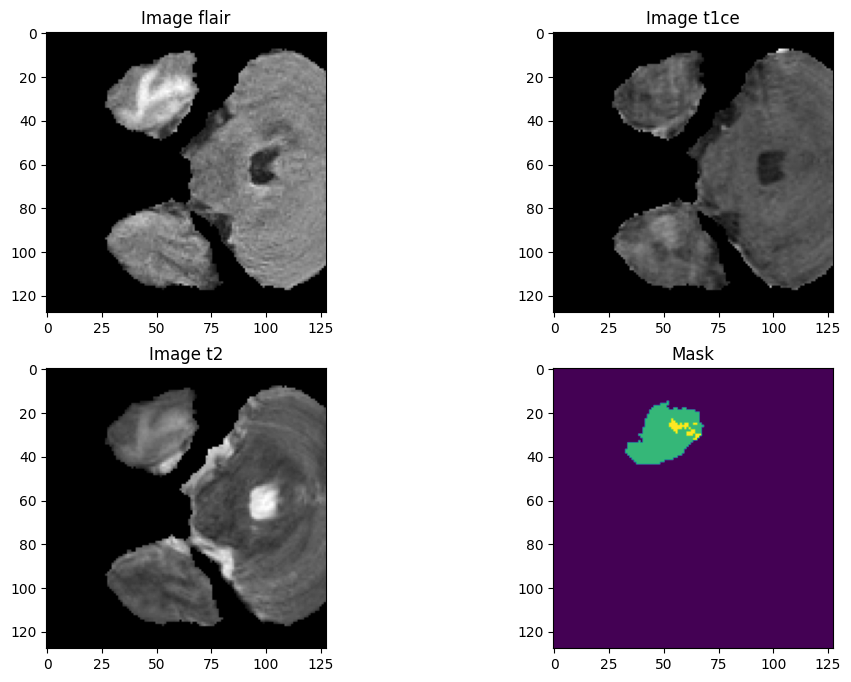

In [17]:

batch_size = 1

train_img_datagen = imageLoader(train_img_dir, train_img_list, 
                                train_mask_dir, train_mask_list, batch_size)

val_img_datagen = imageLoader(val_img_dir, val_img_list, 
                                val_mask_dir, val_mask_list, batch_size)

#Verify generator.... In python 3 next() is renamed as __next__()
# Verify generator.... In python 3 next() is renamed as __next__()
img, msk = train_img_datagen.__next__()

# Select a random image from the batch
img_num = random.randint(0, img.shape[0] - 1)
test_img = img[img_num]
test_mask = msk[img_num]

# Take argmax along the last axis to collapse the one-hot encoding
test_mask = np.argmax(test_mask, axis=3)

# Randomly select a valid slice index
n_slice = random.randint(0, test_mask.shape[2] - 1)  # Fixed to exclude the upper bound

# Plot the slices
plt.figure(figsize=(12, 8))

plt.subplot(221)
plt.imshow(test_img[:, :, n_slice, 0], cmap='gray')
plt.title('Image flair')

plt.subplot(222)
plt.imshow(test_img[:, :, n_slice, 1], cmap='gray')
plt.title('Image t1ce')

plt.subplot(223)
plt.imshow(test_img[:, :, n_slice, 2], cmap='gray')
plt.title('Image t2')

plt.subplot(224)
plt.imshow(test_mask[:, :, n_slice])
plt.title('Mask')

plt.show()



### Matrics and loss and optimizer


In [19]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
import torch.nn.functional as F
from sklearn.metrics import jaccard_score
import numpy as np

# Define Dice Loss
def dice_loss(y_true, y_pred, smooth=1):
    y_pred = torch.sigmoid(y_pred)  # Apply sigmoid for binary segmentation
    y_true_flat = y_true.view(-1)
    y_pred_flat = y_pred.view(-1)
    intersection = (y_true_flat * y_pred_flat).sum()
    return 1 - (2. * intersection + smooth) / (y_true_flat.sum() + y_pred_flat.sum() + smooth)

# Define Focal Loss
class FocalLoss(nn.Module):
    def __init__(self, alpha=0.25, gamma=2):
        super(FocalLoss, self).__init__()
        self.alpha = alpha
        self.gamma = gamma

    def forward(self, y_true, y_pred):
        bce_loss = F.binary_cross_entropy_with_logits(y_pred, y_true, reduction='none')
        p_t = torch.exp(-bce_loss)
        focal_loss = self.alpha * (1 - p_t) ** self.gamma * bce_loss
        return focal_loss.mean()

# Define Combined Loss
class CombinedLoss(nn.Module):
    def __init__(self):
        super(CombinedLoss, self).__init__()
        self.dice = dice_loss
        self.focal = FocalLoss()

    def forward(self, y_true, y_pred):
        dice = self.dice(y_true, y_pred)
        focal = self.focal(y_true, y_pred)
        return dice + focal

# Define IoU Metric
def iou_score(y_true, y_pred, threshold=0.5):
    y_pred = (torch.sigmoid(y_pred) > threshold).float()
    y_true_np = y_true.cpu().numpy().flatten()
    y_pred_np = y_pred.cpu().numpy().flatten()
    return jaccard_score(y_true_np, y_pred_np)

# Dummy Dataset
class DummyDataset(Dataset):
    def __init__(self, num_samples=100, img_size=(128, 128, 128)):
        self.num_samples = num_samples
        self.img_size = img_size

    def __len__(self):
        return self.num_samples

    def __getitem__(self, idx):
        x = torch.rand(3, *self.img_size)  # Random 3-channel volumetric data
        y = torch.randint(0, 2, (4, *self.img_size)).float()  # Random 4-class segmentation masks
        return x, y

# Training Parameters
learning_rate = 0.0001
batch_size = 2
epochs = 2

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Model, Loss, Optimizer
model = HybridUNet(img_channels=3, num_classes=4)
model = model.to(device)  # Move model to GPU if available
criterion = CombinedLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Data Loaders
train_dataset = DummyDataset()
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

# Initialize history dictionary
history = {
    "train_loss": [],
    "train_iou": []
}

# Training Loop
for epoch in range(epochs):
    model.train()
    running_loss = 0.0
    iou_scores = []

    for inputs, targets in train_loader:
        inputs, targets = inputs.to(device), targets.to(device)  # Move data to GPU if available

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(targets, outputs)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        iou_scores.append(iou_score(targets, outputs))

    epoch_loss = running_loss / len(train_loader)
    epoch_iou = np.mean(iou_scores)

    history["train_loss"].append(epoch_loss)
    history["train_iou"].append(epoch_iou)

    print(f"Epoch {epoch + 1}/{epochs}")
    print(f"Loss: {epoch_loss:.4f}, IoU: {epoch_iou:.4f}")

# Save Model
torch.save(model, "hybrid_unet_model.pth")

# Save history
import json
with open("training_history.json", "w") as f:
    json.dump(history, f)

Loaded pretrained weights for efficientnet-b0
Epoch 1/2
Loss: 0.5352, IoU: 0.4287
Epoch 2/2
Loss: 0.5051, IoU: 0.4940


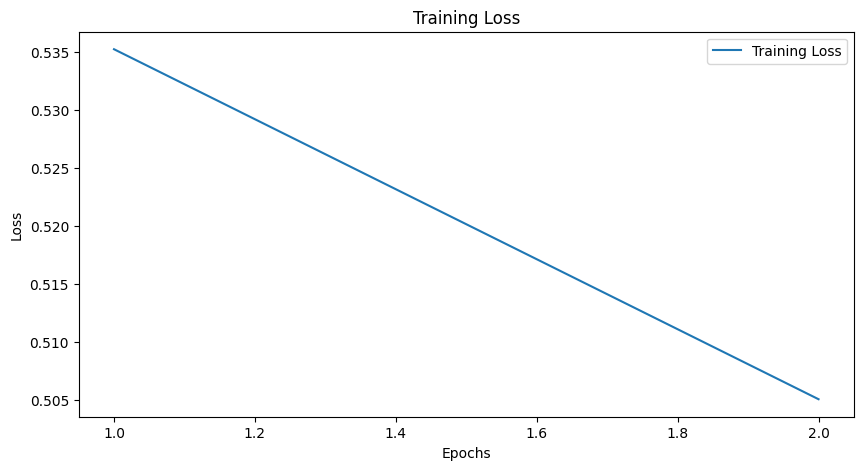

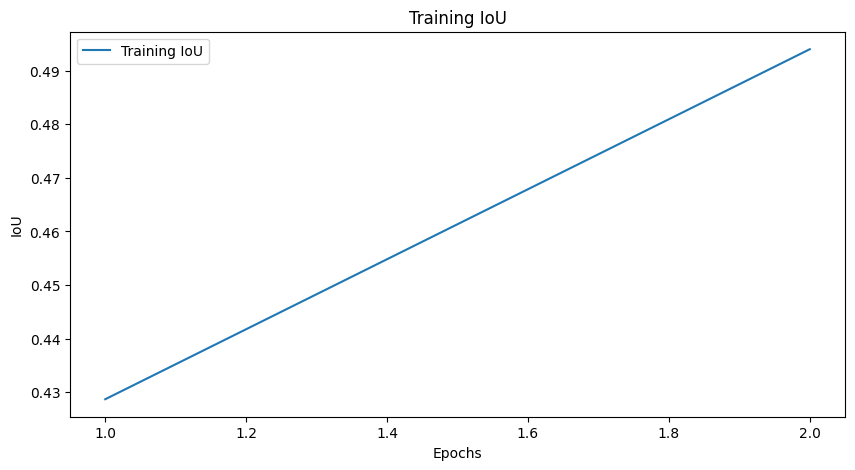

In [20]:
# Plot training loss and IoU
import matplotlib.pyplot as plt

epochs_range = range(1, epochs + 1)

plt.figure(figsize=(10, 5))
plt.plot(epochs_range, history["train_loss"], label="Training Loss")
plt.title("Training Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

plt.figure(figsize=(10, 5))
plt.plot(epochs_range, history["train_iou"], label="Training IoU")
plt.title("Training IoU")
plt.xlabel("Epochs")
plt.ylabel("IoU")
plt.legend()
plt.show()

In [28]:
import os
import nibabel as nib

# Base data directory
data_path = "D:/GIKI\Deep Learning/Project/Dataset/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData"  # Replace with the actual path to your data directory

# List all patient directories
patient_dirs = [os.path.join(data_path, d) for d in os.listdir(data_path) if os.path.isdir(os.path.join(data_path, d))]

# Function to load a patient's data
def load_patient_data(patient_dir):
    """
    Load T1ce, Flair, and Segmentation data for a single patient.

    Args:
        patient_dir (str): Path to the patient's directory.

    Returns:
        t1ce (numpy.ndarray): T1ce image data.
        flair (numpy.ndarray): Flair image data.
        seg (numpy.ndarray): Segmentation mask (ground truth).
    """
    # Construct paths for T1ce, Flair, and segmentation files
    t1ce_path = os.path.join(patient_dir, f"{os.path.basename(patient_dir)}_t1ce.nii")
    flair_path = os.path.join(patient_dir, f"{os.path.basename(patient_dir)}_flair.nii")
    seg_path = os.path.join(patient_dir, f"{os.path.basename(patient_dir)}_seg.nii")

    # Load the NIfTI files
    t1ce = nib.load(t1ce_path).get_fdata()
    flair = nib.load(flair_path).get_fdata()
    seg = nib.load(seg_path).get_fdata()

    return t1ce, flair, seg

# Example: Load data for the first patient
for patient_dir in patient_dirs:
    t1ce, flair, seg = load_patient_data(patient_dir)
    print(f"Loaded data for {os.path.basename(patient_dir)}")
    print(f"T1ce shape: {t1ce.shape}, Flair shape: {flair.shape}, Segmentation shape: {seg.shape}")
    break  # Remove this line to process all patients


Loaded data for BraTS20_Training_001
T1ce shape: (240, 240, 155), Flair shape: (240, 240, 155), Segmentation shape: (240, 240, 155)


In [31]:
def predict_segmentation(patient_dir):
    """
    Predict segmentation for a given patient directory.

    Args:
        patient_dir (str): Path to the patient's directory.

    Returns:
        predicted_segmentation (numpy.ndarray): Predicted segmentation mask.
    """
    t1ce_path = os.path.join(patient_dir, f"{os.path.basename(patient_dir)}_t1ce.nii")
    flair_path = os.path.join(patient_dir, f"{os.path.basename(patient_dir)}_flair.nii")

    # Load NIfTI images
    t1ce = nib.load(t1ce_path).get_fdata()
    flair = nib.load(flair_path).get_fdata()

    # Prepare input volume
    X = np.empty((VOLUME_SLICES, IMG_SIZE, IMG_SIZE, 3))  # Adjusted to 3 channels
    for j in range(VOLUME_SLICES):
        X[j, :, :, 0] = cv2.resize(flair[:, :, j + VOLUME_START_AT], (IMG_SIZE, IMG_SIZE))
        X[j, :, :, 1] = cv2.resize(t1ce[:, :, j + VOLUME_START_AT], (IMG_SIZE, IMG_SIZE))
        X[j, :, :, 2] = cv2.resize(flair[:, :, j + VOLUME_START_AT], (IMG_SIZE, IMG_SIZE))  # Duplicate flair as 3rd channel

    # Normalize input
    X = X / np.max(X)
    X = torch.tensor(X, dtype=torch.float32).permute(3, 0, 1, 2).unsqueeze(0).to(device)  # Shape: (1, C, D, H, W)

    # Predict segmentation
    with torch.no_grad():
        output = model(X)
        predicted_segmentation = torch.softmax(output, dim=1).cpu().numpy()  # Shape: (B, num_classes, D, H, W)

    return predicted_segmentation[0]  # Remove batch dimension
